# 0. Setup

Here are all the libraries that had to be installed before running (since they were not included in colab/pycharm)

In [ ]:
!pip install biopython
!pip install pymatgen
!pip install chemparse
!pip install matminer

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from pymatgen.core import Structure

**Note**: Many of the functions are stored in a seperate `functions.py` file to make this notebook more readable. In general, the idea of why a certain thing was done can usually be found in the notebook, while an explanation for what the function does can be found in the python file. We tried to annotate as much as possible and order them in the same way in the python file as in the notebook so the reader can follow more easily. 

In [2]:
import functions as func

Set working directory so paths are easier to declare (adjust `os.chdir(...)` to the folder where you are running this file from)

In [3]:
os.chdir("C:\\Users\\Yanni\\Desktop\\Final Project")

In [4]:
PCD_folder = "DATA/cifs/PCD/"
ICSD_folder = "DATA/cifs/ICSD/"

PCD_pickle_raw = 'DATA/pickle/PCD_raw.pkl'
ICSD_pickle_raw = 'DATA/pickle/ICSD_raw.pkl'

data_pickle_cleaned = 'DATA/pickle/data_cleaned.pkl'
data_pickle_reduced = 'DATA/pickle/data_reduced.pkl'
data_pickle_shortened = 'DATA/pickle/data_shortened.pkl'


# 1. Loading Data

## Downloading data

### ICSD

Since a lot of data is necessary for this part, part of the data is downloaded from the ICSD database courtesy of FIZ Karlsruhe. This can be done via their API, where the script by github user "simonverret" was used: https://github.com/simonverret/materials_data_api_scripts. 

But since this script downloads the data into a `.csv` file and not `.cif` files (which will be important later down the line), the script was modified to suit our needs! More details about what was modified can be found in `notebooks/1a_Downloading_Data.ipynb`.

In [1]:
import ICSD_download as icd

credentials = icd.get_credentials()
icd.download_all(credentials["loginid"], credentials["password"], min_N = 1, max_N = 5)

logged in ICSD  (token=0BF8D8664C079C29AB4E276E0D525E4E)
materials with 1 elements
Progress: [---->] 100%
received 3199/3199 cif strings
materials with 2 elements
Progress: [---------------------------------------------->] 100%
received 46216/46216 cif strings
materials with 3 elements
Progress: [------------------------------------------------------------------------------------->] 100%
received 85045/85045 cif strings
materials with 4 elements
Progress: [------------------------------------------------------------>] 100%
received 60334/60334 cif strings
materials with 5 elements
Progress: [---------------------------------------->] 100%
received 40133/40133 cif strings
logged out ICSD (token=523FC3D1C4A4406837FD656353D1E2C0)


### PCD

*The PCD dataset was provided by our Assistant, which is why we didn't include the download for that*

## Convert Data

After downloading all the `.cif` files, we want to convert the files into a `pandas.DataFrame` for easier data handling. Our 2 main objectives that we want to achieve to are:

1. Calculate coefficient of thermal expansion
2. Generate feature vectors

Step 1 can be easily handled in a dataframe. Step 2 however, isn't as straightforward. For the feature vectors we want to use **pymatgen** which can load .cif files to create `pymatgen.core.Structure` objects, but when we do operations on the corresponding dataframe, those operations don't translate well and we might loose track of which exact `.cif` files should be loaded afterwards. To circumvent this problem, while creating the dataframe, we attach the `dict` version of the **pymatgen** object to the end, this way we can store all the raw data in one dataframe while also keeping data together when we perform row operations on the dataframe. This will however lead to additional complexity later down the line when we have to fetch the **pymatgen** object out of the dataframe, create the feature vectors and then merge them back in. 

### PCD

Here we actually convert the PCD `.cif` files into a dataframe.

In [72]:
df_PCD_raw = func.load_PCD_cif(PCD_folder)

df_PCD_raw.to_pickle(PCD_pickle_raw)

Loading: PCD cifs
Progress: [------------------->] 100%
Final Report: 7% Failed to load, 144 minutes taken for entire operation


And a quick look at how large the useable raw PCD dataset is:

In [12]:
print(len(df_PCD_raw))

281865


### ICSD

And here we convert the ICSD `.cif` files into a dataframe. 

**Note:** the `.cif` files downloaded from the ICSD database sometimes contain the ' (apostrophe) within the publication title. Because the `MMMCFI2Dict` module reads parts of the file according to the formatting, this messes with some of the files present. We went through the entire list and identified which files contained a loose apostrophe and removed it. If you try to replicate the results, be very mindful of this and maybe try to circumvent this problem from the beginning.

In [8]:
df_ICSD_raw = func.load_ICSD_cif(ICSD_folder)

df_ICSD_raw.to_pickle(ICSD_pickle_raw)

Loading: ICSD cifs
Progress: [------------------->] 100%
Final Report: 2% Failed to load, 155 minutes taken for entire operation


And a quick look at how large the useable raw ICSD dataset is:

In [7]:
print(len(df_ICSD_raw))

229320


# 2. Processing Data

In this section, our main goals are:

1. Clean the data (throw out unneccessary information)
2. Make it more readable
3. Fill in missing data
4. Calculate coefficient of thermal expansion


To start, we load the two saved datasets from the previous step.

In [5]:
df_PCD_raw = pd.read_pickle(PCD_pickle_raw)
df_ICSD_raw = pd.read_pickle(ICSD_pickle_raw)

Then we combine the datasets so that modifications can later be done in one single step

In [6]:
df_raw = pd.concat([df_PCD_raw, df_ICSD_raw])

Overview over the entire raw dataset with all data intact

In [7]:
display(df_raw)

,database,data_,_audit_creation_date,_audit_creation_method,_chemical_formula_structural,_chemical_formula_sum,_chemical_name_mineral,_chemical_compound_source,_chemical_name_structure_type,_chemical_formula_weight,...,_atom_site_aniso_U_23,_atom_site_aniso_B_11,_atom_site_aniso_B_22,_atom_site_aniso_B_33,_atom_site_aniso_B_12,_atom_site_aniso_B_13,_atom_site_aniso_B_23,_atom_site_U_iso_or_equiv,_publ_section_comment,-
0,PCD,PCD_1000001,[2017-12-04],[\nPearson's Crystal Data browser],[Ho Ni~4~ B],[B Ho Ni4],[?],[?],"[CeCo~4~B,hP12,191]",[410.5],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PCD,PCD_1000002,[2017-12-04],[\nPearson's Crystal Data browser],[Tl~2~ W Cl~6~],[Cl6 Tl2 W],[?],[?],"[K~2~PtCl~6~,cF36,225]",[805.3],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PCD,PCD_1000003,[2017-12-04],[\nPearson's Crystal Data browser],[Na~3~ Fe~1.5~ Al~1.5~ [Te O~6~]~2~],[Al1.50 Fe1.50 Na3 O12 Te2],[?],[?],"[Ca~3~Al~2~[SiO~4~]~3~,cI160,230]",[640.4],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PCD,PCD_1000005,[2017-12-04],[\nPearson's Crystal Data browser],[Ag Cu~4~ Nd],[Ag Cu4 Nd],[?],[?],"[MgCu~4~Sn,cF24,216]",[506.3],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,PCD,PCD_1000006,[2017-12-04],[\nPearson's Crystal Data browser],[Ag Cu~4~ Sm],[Ag Cu4 Sm],[?],[?],"[MgCu~4~Sn,cF24,216]",[512.5],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,ICSD,ICSD_977900,[2015-02-01],NaN,[Fe Se],[Fe1 Se1],NaN,NaN,[PbO(oS8)],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.004, 0.0029]",NaN,NaN
0,ICSD,ICSD_977901,[2015-02-01],NaN,[Fe Se],[Fe1 Se1],NaN,NaN,[FeSe#PbO],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0258, 0.02573]",NaN,NaN
0,ICSD,ICSD_977902,[2015-02-01],NaN,[Fe0.96 Se],[Fe0.96 Se1],NaN,NaN,[Nickeline#NiAs],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[0.0284, 0.0482]",NaN,NaN
0,ICSD,ICSD_977903,[2015-02-01],NaN,[Fe Se],[Fe1 Se1],NaN,NaN,[FeSe#PbO],NaN,...,"[0., 0.]",NaN,NaN,NaN,NaN,NaN,NaN,"[0.0131, 0.0119]",NaN,NaN


## Cleaning

Now we can throw out unneccessary columns 

In [8]:
df_fewer_col = func.keep_columns(df_raw)

And rename the remaining columns (except for the ones containing the pymatgen object)

In [9]:
df_renamed = func.rename_columns(df_fewer_col)

During loading, the read data was saved into lists which were then inserted into the dataframe. However almost all of the data is supposed to be in either `int()`, `str()` or `float()` format. So to make it look a bit nicer and handle better when interacting with it, we join the parts of the lists together and remove unneccessary characters. Also, in case we want to create features based on composition (e.g. CBFV), it is useful to have a consistent chemical formula across the entire dataset (since sometimes the formatting can be a bit problematic). For this we use chemparse to create a dictionary and finally turn the dictionary back into a consistent chemical formula.

In [10]:
df_cleaned = func.remove_characters(df_renamed)

At this point, the dataframe is now more readable while still containing most of the original data. Now the size becomes a bit more manageable, so we create an additional save point.

In [12]:
df_cleaned.to_pickle(data_pickle_cleaned)

and look at our data to see what we did in the last steps!

In [13]:
display(df_cleaned)

,FORMULA,SPACEGROUP_SYM,SPCAEGROUP_NO,TEMPERATURE,CELL_LENGTH_A,CELL_LENGTH_B,CELL_LENGTH_C,ALPHA,BETA,GAMMA,...,PRESSURE,DENSITY,ELEMENT_COUNT,DATABASE,REFERENCE,@module,@class,charge,lattice,sites
ID,,,,,,,,,,,,,,,,,,,,,
PCD_1000001,B1.0Ho1.0Ni4.0,P6/mmm,191,300,4.9696,4.9696,6.9419,90,90,120,...,NaN,9.18,3,PCD,"(2000) 215, 481-482",pymatgen.core.structure,Structure,0.0,"{'matrix': [[4.9696, 0.0, 3.043002366521343e-1...","[{'species': [{'element': 'Ho', 'occu': 1.0}],..."
PCD_1000002,Cl6.0Tl2.0W1.0,Fm-3m,225,293,9.8873,9.8873,9.8873,90,90,90,...,NaN,5.53,3,PCD,"(1998) 213, 472-?",pymatgen.core.structure,Structure,0.0,"{'matrix': [[9.8873, 0.0, 6.054225148604813e-1...","[{'species': [{'element': 'Tl', 'occu': 1.0}],..."
PCD_1000003,Al1.5Fe1.5Na3.0O12.0Te2.0,Ia-3d,230,297,12.391,12.391,12.391,90,90,90,...,NaN,4.47,5,PCD,"(1999) 214, 151-152",pymatgen.core.structure,Structure,0.0,"{'matrix': [[12.391, 0.0, 7.587299244117427e-1...","[{'species': [{'element': 'Na', 'occu': 1.0}],..."
PCD_1000005,Ag1.0Cu4.0Nd1.0,F-43m,216,?,7.234,7.234,7.234,90,90,90,...,NaN,8.88,3,PCD,"(1976) 34, 230-232",pymatgen.core.structure,Structure,0.0,"{'matrix': [[7.234, 0.0, 4.4295474725159767e-1...","[{'species': [{'element': 'Nd', 'occu': 1.0}],..."
PCD_1000006,Ag1.0Cu4.0Sm1.0,F-43m,216,?,7.186,7.186,7.186,90,90,90,...,NaN,9.17,3,PCD,"(1976) 34, 230-232",pymatgen.core.structure,Structure,0.0,"{'matrix': [[7.186, 0.0, 4.40015594933644e-16]...","[{'species': [{'element': 'Sm', 'occu': 1.0}],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICSD_977900,Fe1.0Se1.0,Cmma,67,40.,5.3104,5.3317,5.4879,90.,90.,90.,...,NaN,5.76,2,ICSD,"(nan) nan, nan-nan",pymatgen.core.structure,Structure,0.0,"{'matrix': [[5.3104, 0.0, 3.2516821810960517e-...","[{'species': [{'element': 'Fe', 'oxidation_sta..."
ICSD_977901,Fe1.0Se1.0,P4/nmmZ,129,673.,3.828,3.828,5.5821,90.,90.,90.,...,NaN,5.47,2,ICSD,"(nan) nan, nan-nan",pymatgen.core.structure,Structure,0.0,"{'matrix': [[3.828, 0.0, 2.343973973568034e-16...","[{'species': [{'element': 'Fe', 'oxidation_sta..."
ICSD_977902,Fe0.96Se1.0,P63/mmc,194,773.,3.7565,3.7565,5.9621,90.,90.,120.,...,NaN,6.04,2,ICSD,"(nan) nan, nan-nan",pymatgen.core.structure,Structure,0.00192,"{'matrix': [[3.7565, 0.0, 2.300192850498516e-1...","[{'species': [{'element': 'Fe', 'oxidation_sta..."


And an overview over the total number of entries sorted by database and number of different atoms present

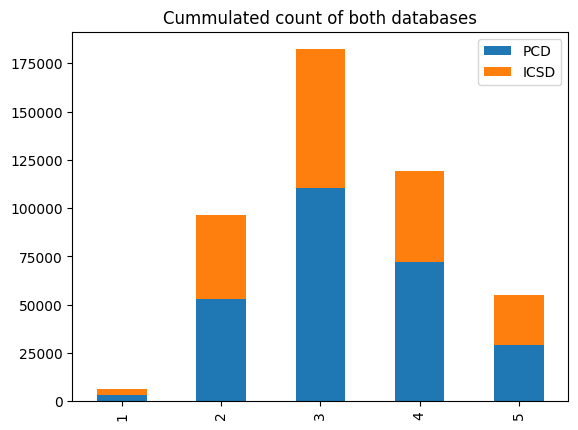

In [111]:
max_elm = 5

df = pd.DataFrame([[df_cleaned['ELEMENT_COUNT'].loc[(df_cleaned['DATABASE'] == 'PCD')].value_counts().loc[i] for i in range(1,max_elm+1)] ,[ df_cleaned['ELEMENT_COUNT'].loc[(df_cleaned['DATABASE'] == 'ICSD')].value_counts().loc[i] for i in range(1,max_elm+1)]], columns=list(range(1,max_elm+1))).transpose()
df.rename(columns={0:'PCD',1:'ICSD'}, inplace=True)

fig = df.plot(kind='bar', stacked=True).set(title='Cummulated count of both databases')

## Manipulate Data

let's load the cleaned dataset

In [5]:
df_cleaned = pd.read_pickle(data_pickle_cleaned)

Fill missing **temperature** and **pressure** values with standard room conditions. While it is possible that for some entries, the creators forgot to add the correct **temperature** & **pressure** values, this is only going to affect a very small subset of the larger dataset. Therefore we believe it is safe to assume that this will not have a major negative effect.

In [6]:
room_temp = 293.15
room_press = 101.325

df_filled = func.fill_missing_values(df_cleaned, room_temp, room_press)

Get an overview over the temperature values. We can see that some have 293K instead of the 293.15K listed in ICSD, which is probably due to the exact definitions of room temperature & pressure used. But a 0.15K difference shouldn't affect calculations too much (hopefully)

In [8]:
display(df_filled['TEMPERATURE'].value_counts())

293.15     349426
293.00      34877
298.00      13674
295.00       9968
300.00       9429
            ...  
178.60          1
171.40          1
385.10          1
360.70          1
2621.00         1
Name: TEMPERATURE, Length: 3061, dtype: int64

To get more reliable datapoints, we want to remove all materials that only have 1 or 2 corresponding entries in the dataset. This ensures that if a material hasn't been properly recorded, we still have at least 2 other valid datapoints.

By removing materials without enough entries, the dataset was modified to
Kept: 231408 entries, 33182 crystals
Deleted: 279777 entries, 230053 crystals


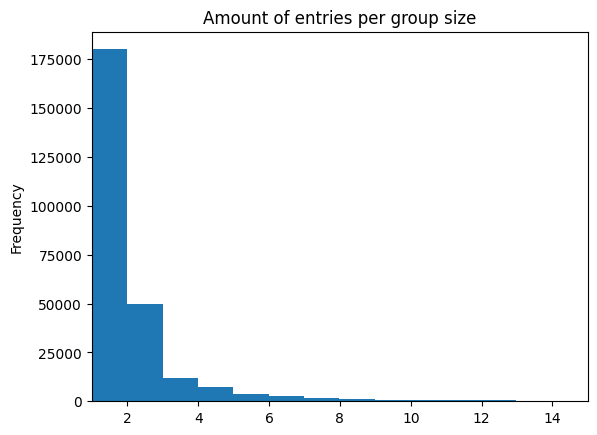

In [9]:
group_size = 3

df_restricted, entries = func.remove_few_entries(df_filled, group_size)

print('By removing materials without enough entries, the dataset was modified to')
print('Kept: ' + str(entries['kept entries']) + ' entries, ' + str(entries['kept crystals']) + ' crystals')
print('Deleted: ' + str(entries['removed entries']) + ' entries, ' + str(entries['removed crystals']) + ' crystals')

func.grouped_histogram(df_filled, 'Amount of entries per group size')

While the dataset is much shorter now, there are still some loose NaN values. So we remove most of them to keep it to relevant entries.

In [11]:
df_shortened, lengths = func.drop_NaN(df_restricted)

print('Removed ' + str(lengths['removed entries']) + ' entries')

Removed 6893 entries


Now the dataset should be ready to calculate the coefficient of thermal expansion, so before that we create and additional save point for easier returning later!

In [13]:
df_shortened.to_pickle(data_pickle_shortened)

And a look at the processed dataset:

In [14]:
display(df_shortened)

,FORMULA,SPACEGROUP_SYM,SPCAEGROUP_NO,TEMPERATURE,CELL_LENGTH_A,CELL_LENGTH_B,CELL_LENGTH_C,ALPHA,BETA,GAMMA,...,PRESSURE,DENSITY,ELEMENT_COUNT,DATABASE,REFERENCE,@module,@class,charge,lattice,sites
ID,,,,,,,,,,,,,,,,,,,,,
PCD_1000001,B1.0Ho1.0Ni4.0,P6/mmm,191,300.00,4.9696,4.9696,6.9419,90,90,120,...,293.15,9.18,3,PCD,"(2000) 215, 481-482",pymatgen.core.structure,Structure,0.0,"{'matrix': [[4.9696, 0.0, 3.043002366521343e-1...","[{'species': [{'element': 'Ho', 'occu': 1.0}],..."
PCD_1000005,Ag1.0Cu4.0Nd1.0,F-43m,216,293.15,7.234,7.234,7.234,90,90,90,...,293.15,8.88,3,PCD,"(1976) 34, 230-232",pymatgen.core.structure,Structure,0.0,"{'matrix': [[7.234, 0.0, 4.4295474725159767e-1...","[{'species': [{'element': 'Nd', 'occu': 1.0}],..."
PCD_1000006,Ag1.0Cu4.0Sm1.0,F-43m,216,293.15,7.186,7.186,7.186,90,90,90,...,293.15,9.17,3,PCD,"(1976) 34, 230-232",pymatgen.core.structure,Structure,0.0,"{'matrix': [[7.186, 0.0, 4.40015594933644e-16]...","[{'species': [{'element': 'Sm', 'occu': 1.0}],..."
PCD_1000007,Ag1.0Cu4.0Gd1.0,F-43m,216,293.15,7.163,7.163,7.163,90,90,90,...,293.15,9.39,3,PCD,"(1976) 34, 230-232",pymatgen.core.structure,Structure,0.0,"{'matrix': [[7.163, 0.0, 4.3860725111462456e-1...","[{'species': [{'element': 'Gd', 'occu': 1.0}],..."
PCD_1000008,Ag1.0Cu4.0Tb1.0,F-43m,216,293.15,7.148,7.148,7.148,90,90,90,...,293.15,9.48,3,PCD,"(1976) 34, 230-232",pymatgen.core.structure,Structure,0.0,"{'matrix': [[7.148, 0.0, 4.3768876601526403e-1...","[{'species': [{'element': 'Tb', 'occu': 1.0}],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ICSD_760462,Cs2.0I6.0Sn1.0,Fm-3m,225,293.15,11.646,11.646,11.646,90.,90.,90.,...,293.15,4.82,3,ICSD,"(nan) nan, nan-nan",pymatgen.core.structure,Structure,0.0,"{'matrix': [[11.646, 0.0, 7.131118311435038e-1...","[{'species': [{'element': 'Cs', 'oxidation_sta..."
ICSD_760468,Br6.0Cs2.0Sn1.0,Fm-3m,225,293.15,11.646,11.646,11.646,90.,90.,90.,...,293.15,3.63,3,ICSD,"(nan) nan, nan-nan",pymatgen.core.structure,Structure,0.0,"{'matrix': [[11.646, 0.0, 7.131118311435038e-1...","[{'species': [{'element': 'Cs', 'oxidation_sta..."
ICSD_977900,Fe1.0Se1.0,Cmma,67,40.00,5.3104,5.3317,5.4879,90.,90.,90.,...,293.15,5.76,2,ICSD,"(nan) nan, nan-nan",pymatgen.core.structure,Structure,0.0,"{'matrix': [[5.3104, 0.0, 3.2516821810960517e-...","[{'species': [{'element': 'Fe', 'oxidation_sta..."


## Calculate CTE

In [5]:
df_shortened = pd.read_pickle(data_pickle_shortened)

In [8]:
spacing = 3

df_binned = func.temperature_bins(df_shortened, spacing)

In [10]:
df2_averaged = func.average_temperature(df_binned)

In [12]:
display(df2_averaged)

TEMPERATURE  CELL_LENGTH_A  CELL_LENGTH_B  \
FORMULA SPACEGROUP_SYM                                              
        C12/c1               292.50       7.311900      14.179000   
        C12/c1               293.15       9.191800       8.836620   
        C12/m1               292.50      12.755033      14.129833   
        C12/m1               293.15       8.614825      13.885473   
        C121                 293.15       6.382480      10.080340   
...                             ...            ...            ...   
Zr1.0   P63/mmc              292.50       3.233200       3.233200   
        P63/mmc              293.15       3.229812       3.229812   
        P63/mmc              295.50       3.249650       3.249650   
        P63/mmc              298.50       3.232100       3.232100   
        P63/mmc              301.50       3.232100       3.232100   

                        CELL_LENGTH_C       VOLUME  
FORMULA SPACEGROUP_SYM                              
        C12/c1              10.170000  1054.400000  
        C12/c1              18.973000  1304.436000  
        C12/m1               5.317500   816.166667  
        C12/m1               7.586611   778.300313  
        C121                12.251920   999.248000  
...                               ...          ...  
Zr1.0   P63/mmc              5.146600    46.590000  
        P63/mmc              5.139830    46.440833  
        P63/mmc              5.182600    47.400000  
        P63/mmc              5.147250    46.565000  
        P63/mmc              5.147700    46.570000  

[75040 rows x 5 columns]

In [8]:
df_filled = df_shortened.copy()

group_col = ['FORMULA','SPACEGROUP_SYM']

df_return['group'] = df_filled[group_col].astype('string').agg(' '.join, axis=1)
df_return[group_col] = df_filled[group_col]
df_return = df_return.set_index('group')

Experimental `pandas.DataFrame` to `pymatgen.Structure` converter

In [73]:
a = df_cleaned[['@module','@class','charge','lattice','sites']]
b = a.to_dict('records')

In [77]:
struccc = Structure.from_dict(b[1])

In [78]:
display(struccc)

Structure Summary
Lattice
    abc : 3.863 3.863 3.863
 angles : 90.0 90.0 90.0
 volume : 57.646656647
      A : 3.863 0.0 2.3654052925531126e-16
      B : 6.212177795700847e-16 3.863 2.3654052925531126e-16
      C : 0.0 0.0 3.863
    pbc : True True True
PeriodicSite: Pt:0.500, Rh:0.500 (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Pt:0.500, Rh:0.500 (0.0000, 1.9315, 1.9315) [0.0000, 0.5000, 0.5000]
PeriodicSite: Pt:0.500, Rh:0.500 (1.9315, 0.0000, 1.9315) [0.5000, 0.0000, 0.5000]
PeriodicSite: Pt:0.500, Rh:0.500 (1.9315, 1.9315, 0.0000) [0.5000, 0.5000, 0.0000]